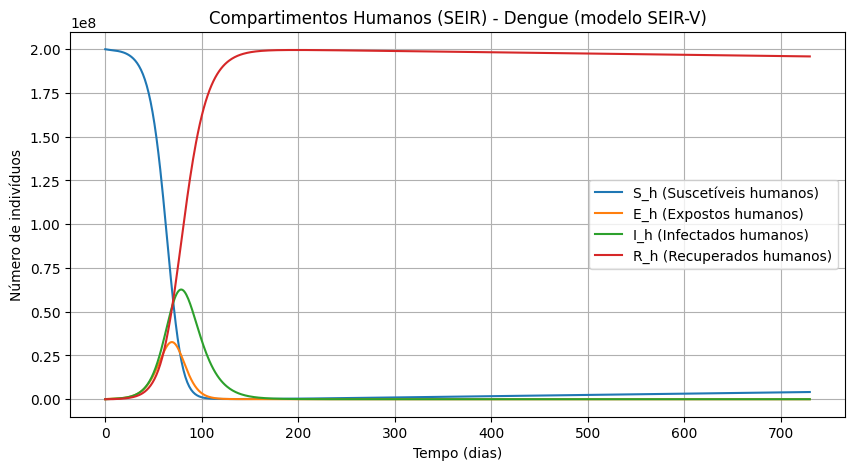

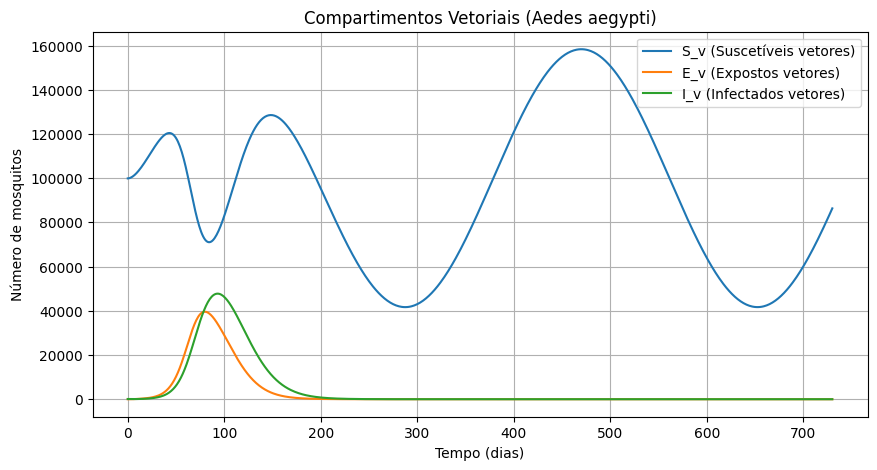

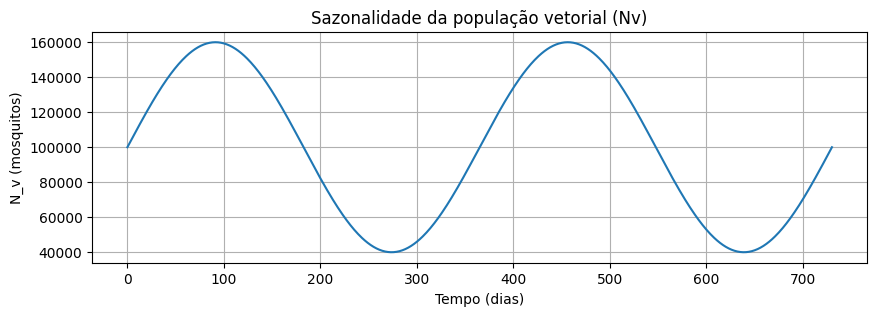

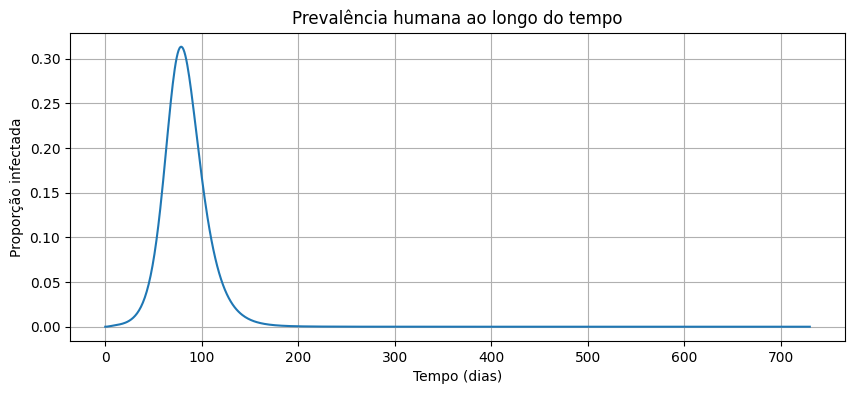

Máximo de infectados humanos (absoluto): 62676295 no dia 79


In [2]:
# Simulação de um modelo SEIR com vetor (SEIR-V) para dengue usando scipy.integrate.odeint
# Gráficos gerados: (1) Compartimentos humanos S_h, E_h, I_h, R_h; (2) Compartimentos vetoriais S_v, E_v, I_v.
# A sazonalidade da população de mosquitos é modelada como variação sinusoidal do recrutamento (ou tamanho efetivo).

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parâmetros do modelo
beta_hv = 0.5    # taxa de transmissão vetor -> humano
beta_vh = 0.3    # taxa de transmissão humano -> vetor
sigma_h = 1/6.0   # 1/incubação humana (dias^-1) ~ 6 dias de incubação
sigma_v = 1/10.0  # 1/incubação no vetor (dias^-1) ~ 10 dias
gamma_h = 1/15.0   # recuperação humana (dias^-1) ~ 15 dias de infectividade
mu_h = 1/(75*365) # mortalidade natural humana (~75 anos), dias^-1 (pequeno)
mu_v_base = 1/14.0 # mortalidade do mosquito média 14 dias sem sazonalidade (dias^-1)

# Populações (valores iniciais)
N_h = 200_000_000    # população brasileira aproximada
Ih0 = 10           # infectados iniciais
Eh0 = 0
Rh0 = 0
Sh0 = N_h - Ih0 - Eh0 - Rh0

# Vetores
Nv_mean = 100_000  # valor médio da população de mosquito
# Sazonalidade dos mosquitos: amplitude (fração) e fase
amp = 0.6          # amplitude da sazonalidade (0 a 1)
phase = 0.0        # fase da senoide (dias)
# Podemos modelar Nv(t) = Nv_mean * (1 + amp * sin(2*pi*(t/365) + phase))
# Condições iniciais vetoriais (assumindo nenhum exposto inicialmente)
Iv0 = 100
Ev0 = 0
Sv0 = Nv_mean - Iv0 - Ev0

# Vetor de tempo (2 anos)
dias = 365 * 2
t = np.linspace(0, dias, dias+1)

def Nv_seasonal(t):
    """População de mosquitos sazonal (valor absoluto)."""
    return Nv_mean * (1 + amp * np.sin(2 * np.pi * (t/365.0) + phase))

def deriv(y, t, beta_hv, beta_vh, sigma_h, sigma_v, gamma_h, mu_h, mu_v_base):
    S_h, E_h, I_h, R_h, S_v, E_v, I_v = y
    # população de mosquitos no tempo t (sazonal)
    Nv_t = Nv_seasonal(t)
    # adotamos mu_v dependente do ambiente indiretamente (poderia variar com temperatura)
    # aqui mantemos mu_v constante para simplificar; alternativamente, poderia ser função de t
    mu_v = mu_v_base

    # Forças de infecção (assumindo mistura homogênea e que a taxa de picadas está engloba em beta)
    lambda_h = beta_hv * (I_v / Nv_t) if Nv_t > 0 else 0.0   # risco para humanos de serem infectados por vetores
    lambda_v = beta_vh * (I_h / N_h) if N_h > 0 else 0.0     # risco para vetores de serem infectados por humanos

    # Equações do modelo (valores absolutos, não frações)
    dS_h_dt = mu_h * N_h - lambda_h * S_h - mu_h * S_h
    dE_h_dt = lambda_h * S_h - sigma_h * E_h - mu_h * E_h
    dI_h_dt = sigma_h * E_h - gamma_h * I_h - mu_h * I_h
    dR_h_dt = gamma_h * I_h - mu_h * R_h

    # Para vetores, assumimos taxa de nascimento ajustada para manter Nv_t (recrutamento)
    # modelo simplificado: recrutamento = mu_v * Nv_t  --> mantém em média a população Nv_t
    recruitment_v = mu_v * Nv_t
    dS_v_dt = recruitment_v - lambda_v * S_v - mu_v * S_v
    dE_v_dt = lambda_v * S_v - sigma_v * E_v - mu_v * E_v
    dI_v_dt = sigma_v * E_v - mu_v * I_v

    return [dS_h_dt, dE_h_dt, dI_h_dt, dR_h_dt, dS_v_dt, dE_v_dt, dI_v_dt]

# Condições iniciais concatenadas
y0 = [Sh0, Eh0, Ih0, Rh0, Sv0, Ev0, Iv0]

# Resolver ODEs
sol = odeint(deriv, y0, t, args=(beta_hv, beta_vh, sigma_h, sigma_v, gamma_h, mu_h, mu_v_base))
S_h, E_h, I_h, R_h, S_v, E_v, I_v = sol.T

# Plots
# 1) Humanos: S, E, I, R (um gráfico)
plt.figure(figsize=(10,5))
plt.plot(t, S_h, label='S_h (Suscetíveis humanos)')
plt.plot(t, E_h, label='E_h (Expostos humanos)')
plt.plot(t, I_h, label='I_h (Infectados humanos)')
plt.plot(t, R_h, label='R_h (Recuperados humanos)')
plt.xlabel('Tempo (dias)')
plt.ylabel('Número de indivíduos')
plt.title('Compartimentos Humanos (SEIR) - Dengue (modelo SEIR-V)')
plt.legend()
plt.grid(True)
plt.show()

# 2) Vetores: S_v, E_v, I_v (um gráfico)
plt.figure(figsize=(10,5))
plt.plot(t, S_v, label='S_v (Suscetíveis vetores)')
plt.plot(t, E_v, label='E_v (Expostos vetores)')
plt.plot(t, I_v, label='I_v (Infectados vetores)')
plt.xlabel('Tempo (dias)')
plt.ylabel('Número de mosquitos')
plt.title('Compartimentos Vetoriais (Aedes aegypti)')
plt.legend()
plt.grid(True)
plt.show()

# 3) População de mosquitos sazonal para referência (um gráfico separado)
plt.figure(figsize=(10,3))
plt.plot(t, Nv_seasonal(t), label='N_v (sazonal)')
plt.xlabel('Tempo (dias)')
plt.ylabel('N_v (mosquitos)')
plt.title('Sazonalidade da população vetorial (Nv)')
plt.grid(True)
plt.show()

# 4) Indicador simples: prevalência humana I_h/N_h (um gráfico separado)
plt.figure(figsize=(10,4))
plt.plot(t, I_h / N_h, label='Prevalência humana (I_h/N_h)')
plt.xlabel('Tempo (dias)')
plt.ylabel('Proporção infectada')
plt.title('Prevalência humana ao longo do tempo')
plt.grid(True)
plt.show()

# Exibir alguns números resumo
peak_I = I_h.max()
day_peak = t[I_h.argmax()]
print(f"Máximo de infectados humanos (absoluto): {peak_I:.0f} no dia {day_peak:.0f}")

